In [1]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
from IPython.display import clear_output, Image, display
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
from tf_conversions import posemath

In [2]:
rospy.init_node('notebook')

In [3]:
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/stereo/right/image_flipped', 'sensor_msgs/Image'],
 ['/dvrk/PSM3/goal_reached', 'std_msgs/Bool'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/console/teleop/scale', 'std_msgs/Float32'],
 ['/dvrk/PSM3/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/PSM3/current_state', 'std_msgs/String'],
 ['/dvrk/PSM3/manip_clutch', 'std_msgs/Bool'],
 ['/dvrk/PSM3/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/position_cartesian_desired', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/pos

In [4]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_flipped', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_flipped', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

VkJveChjaGlsZHJlbj0oSEJveChjaGlsZHJlbj0oQnV0dG9uKGRlc2NyaXB0aW9uPXUnU3RvcCcsIHN0eWxlPUJ1dHRvblN0eWxlKCkpLCkpLCBPdXRwdXQobGF5b3V0PUxheW91dChib3JkZXLigKY=


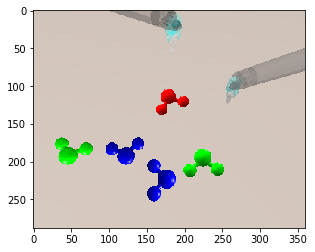

In [5]:
plt.imshow(left_image)

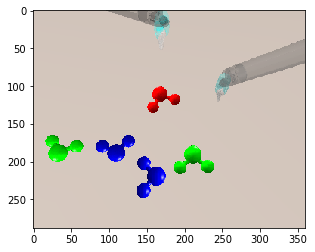

In [6]:
plt.imshow(right_image)

In [7]:
print("LEFT CAM")
print(left_camera_info)
print("RIGHT_CAM")
print(right_camera_info)

LEFT CAM
header: 
  seq: 44417
  stamp: 
    secs: 1590648540
    nsecs:  94176292
  frame_id: "left_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, 0.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: True
RIGHT_CAM
header: 
  seq: 44417
  stamp: 
    secs: 1590648540
    nsecs:  94176292
  frame_id: "right_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, -1.5598017585329753, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0


In [8]:
psm1 = None 
ecm = None
suj = None
debug_output = widgets.Output(layout={'border': '1px solid black'})

with debug_output:
    global psm1, ecm
    psm1 = dvrk.psm('PSM1')
    ecm = dvrk.ecm('ECM')
    psm2 = dvrk.psm('PSM2')

HARDCODED_ECM_POS = np.array([0.0, 0.0, 0.05, 0.0])

In [9]:
tf_listener = tf.TransformListener()

In [10]:
tf_listener.getFrameStrings()

/opt/ros/melodic/lib/python2.7/dist-packages/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


[]

In [11]:
import time
time.sleep(5)
ecm.move_joint(HARDCODED_ECM_POS)

[ERROR] [1590648544.697856]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7fbdab92b990>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/ubuntu/catkin_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity_joint_current.resize(len(data.velocity))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False



True

[INFO] [1590648545.841527]: Number of feature files:
[INFO] [1590648545.845754]: 1
[INFO] [1590648545.849296]: Feature ranges: 
[INFO] [1590648545.851668]: [[[  0.  37.  45.]
  [ 23. 100. 100.]]]
[INFO] [1590648545.865957]: 0
[INFO] [1590648545.868783]: Size: 59.54829972383762
[INFO] [1590648545.870063]: Height: 288 Width: 360
[INFO] [1590648545.871967]: [x: 183.0
y: 125.0]
[INFO] [1590648545.875287]: [[183. 125.]]
[INFO] [1590648545.879199]: Size: 0.0
[INFO] [1590648545.880501]: Height: 288 Width: 360
[INFO] [1590648545.884465]: [x: 172.0
y: 122.0]
[INFO] [1590648545.886142]: [[172. 122.]]
[INFO] [1590648545.887716]: Size: 0.0
type: 
  data: "centroids"
center: 
  x: 183
  y: 125
zoom: 
  data: 1.0
yaw_angle: 
  data: 0.0
points: 
  - 
    x: 183.0
    y: 125.0


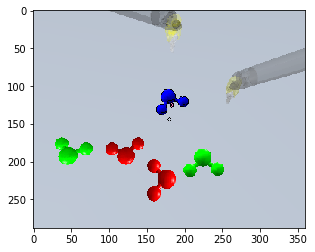

In [12]:
import image_geometry
import vision_pipeline
BALL_FEAT_PATH = '../autonomous_surgical_camera/auto_cam/config/features/red_ball.csv'
cv2.imwrite('left.png', left_image)
fp = vision_pipeline.feature_processor([BALL_FEAT_PATH], 'left.png')
left_feats, left_frame = fp.Centroids(left_image_msg)
right_feats, right_frame = fp.Centroids(right_image_msg)
print(left_feats)
plt.imshow(left_frame)

type: 
  data: "centroids"
center: 
  x: 172
  y: 122
zoom: 
  data: 1.0
yaw_angle: 
  data: 0.0
points: 
  - 
    x: 172.0
    y: 122.0


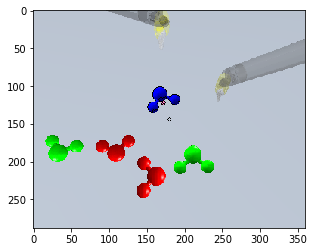

In [13]:
print(right_feats)
plt.imshow(right_frame)

[INFO] [1590648546.423810]: Number of feature files:
[INFO] [1590648546.425065]: 1
[INFO] [1590648546.429661]: Feature ranges: 
[INFO] [1590648546.431592]: [[[  0.  37.  45.]
  [ 23. 100. 100.]]]
[INFO] [1590648546.439641]: 0
[INFO] [1590648546.443259]: Size: 59.54829972383762
[INFO] [1590648546.444786]: Height: 288 Width: 360
[INFO] [1590648546.451923]: [x: 183.0
y: 125.0]
[INFO] [1590648546.453847]: [[183. 125.]]
[INFO] [1590648546.455618]: Size: 0.0
[INFO] [1590648546.459600]: Height: 288 Width: 360
[INFO] [1590648546.462374]: [x: 172.0
y: 122.0]
[INFO] [1590648546.463959]: [[172. 122.]]
[INFO] [1590648546.470071]: Size: 0.0
(-0.0013636363636363637, 0.008636363636363636, 0.14180015986663413)


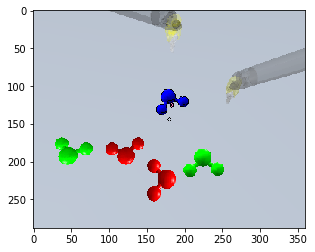

In [14]:
pick_and_place_utils = None
from pick_and_place_utils import get_feat_position_and_img, tf_to_pykdl_frame, PSM_J1_TO_BASE_LINK_TF

stereo_cam = image_geometry.StereoCameraModel()
stereo_cam.fromCameraInfo(left_camera_info, right_camera_info)
ball_pos_cam, left_frame = get_feat_position_and_img(left_image_msg, right_image_msg, stereo_cam)
print(ball_pos_cam)
plt.imshow(left_frame)

In [15]:
ball_pos_cam = PyKDL.Vector(*ball_pos_cam)
tf_cam_to_jp21 = tf_to_pykdl_frame(tf_listener.lookupTransform('ecm_pitch_link_1', 'camera', rospy.Time()))
ball_pos_jp21 = tf_cam_to_jp21 * ball_pos_cam
ball_pos_jp21

[   -0.369364,     -0.1925,  0.00136365]

In [16]:
# did this to confirm that the /tf transforms provided by dVRK are within margin of error of 
# actual sim coordinates
tf_insertion_to_jp21 = tf_listener.lookupTransform('ecm_pitch_link_1', 'ecm_insertion_link', rospy.Time())
tf_insertion_to_jp21

([-0.3780000000000002, 0.3322000000018508, 2.448874436566939e-13],
 [0.7071067811848165,
  -6.677109938001597e-17,
  -1.2669696976051526e-16,
  0.707106781188279])

In [17]:
tf_jp21_to_world = tf_to_pykdl_frame(tf_listener.lookupTransform('world', 'Jp21_ECM', rospy.Time()))
ball_pos_world = tf_jp21_to_world * ball_pos_jp21
# i'm a winner
ball_pos_world

[    -1.48863,  0.00177209,    0.655824]

In [18]:
tf_world_to_psm2_j1 = tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM2', 'world', rospy.Time()))
ball_pos_psm2_j1 = tf_world_to_psm2_j1 * ball_pos_world
# ok not off by *too* much
ball_pos_psm2_j1

[     0.14592,    0.142964,  0.00168367]

In [19]:
ball_pos_psm2_main = PSM_J1_TO_BASE_LINK_TF * ball_pos_psm2_j1
ball_pos_psm2_main

[    -0.14592, -0.00168367,   -0.142964]

#### 

In [20]:
psm2_rot = psm2.get_current_position().M
psm2_pos = psm2.get_current_position().p
psm2_pos

[   -0.150783,  -0.0157269,   -0.117741]

In [21]:
psm2.move(ball_pos_psm2_main)

True

In [22]:
cam_z_vec_world = (tf_jp21_to_world * tf_cam_to_jp21).M * PyKDL.Vector(0, 0, 1.0)
cam_z_vec_psm2_main = (PSM_J1_TO_BASE_LINK_TF * tf_world_to_psm2_j1).M * cam_z_vec_world
psm2.move_joint_one(0., 5)
psm2.open_jaw()
psm2.dmove(0.03 * cam_z_vec_psm2_main)
psm2.close_jaw()

True

In [23]:
psm2.dmove(PyKDL.Vector(0, 0, 0.05))

True